Produce very simplistic plots to have a qualitative sanity check of the scripts executed during an experiment.


In [1]:
# Load the python modules.
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from dapper import Chronology, with_recursion
import pprint
import seaborn as sns
import tensorflow.keras.backend as K

from l2s_utils import plot_L96_2D, default_param, buildmodel

#Insert the common folder in the path (to be able to load python module)
sys.path.insert(0,os.path.join(os.path.pardir,'common'))
from toolbox import load_config

Initializing DAPPER...

but is not supported by current backend: module://ipykernel.pylab.backend_inline.
Try another backend in your settings, e.g., mpl.use('Qt5Agg').
...Done
PS: Turn off this message in your configuration: dpr_config.ini


## Set the name of the experiment

In [2]:
# Name of the experiment
fexp = './config/ref_test.yml'

# If several parameter, which set to plot
ipar = 0

# If several members, which member to plot
imemb = 0

# Length of the plot (in MTU):
Tplot = 5.

# For figure representing only one component, index if the component (in space space):
icomp = 15

# Other parameters
fpaths = './config/paths.yml'

# Truncated model
fmodel = './config/model_trunc.yml'

In [17]:
# Set the paths
used_params = {'p','dtObs','std_m','std_o','Nfil_train','T','N','seed'}

paths = load_config(fpaths)
exp = load_config(fexp)
model = load_config(fmodel)
template = exp['template']
expdir = os.path.join(paths['rootdir'],exp['savedir'])
weightsdir = os.path.join(paths['rootdir'],exp['weightsdir'])
print('Experiment directory:',expdir)

Experiment directory: ../data/L2S/simul/test


In [4]:
# Set the parameters of the experiment
lparam = {k:exp.get(k,[default_param[k]]) for k in used_params}

# Sequence of all the combination of the parameters
seq_param = ParameterGrid(lparam)
dparam = seq_param[ipar]
pprint.pprint(dparam)

{'N': 20,
 'Nfil_train': 1,
 'T': 15.0,
 'dtObs': 0.05,
 'p': 36,
 'seed': 10,
 'std_m': 0.06,
 'std_o': 0.1}


### 1. simul.py / simul_phyical_model.ipynb

In [5]:
# Load truth simul
fname_truth = os.path.join(expdir,template['truth'].format(**dparam))
data_truth = np.load(fname_truth)

chrono_truth = Chronology(T=data_truth['T'],dt=float(data_truth['dt']),dtObs=dparam['dtObs'])
xx_truth = data_truth['xx']
      
# Load trunc simul
fname_trunc = os.path.join(expdir,template['trunc'].format(**dparam))
data_trunc = np.load(fname_trunc)
chrono_trunc = Chronology(T=data_trunc['T'],dt=float(data_trunc['dt']),dtObs=dparam['dtObs'])
xx_trunc = data_trunc['xx']

# Print Size
print('Size of the true dataset (time steps, ensemble size, state size):',xx_truth.shape)
print('Size of the trunc dataset (time steps, ensemble size, state size):',xx_trunc.shape)

# Extract the common state vector
xxNu = xx_truth[...,:xx_trunc.shape[-1]]

# Some check
assert data_truth['T'] == dparam['T']
assert data_trunc['T'] == dparam['T']
assert np.linalg.norm(chrono_truth.ttObs-chrono_trunc.ttObs) == 0.

# Check if the initial state is the same
assert(np.linalg.norm(xxNu[0] - xx_trunc[0]))==0.

# Close files
data_truth.close()
data_trunc.close()


Size of the true dataset (time steps, ensemble size, state size): (3001, 20, 396)
Size of the trunc dataset (time steps, ensemble size, state size): (1501, 20, 36)


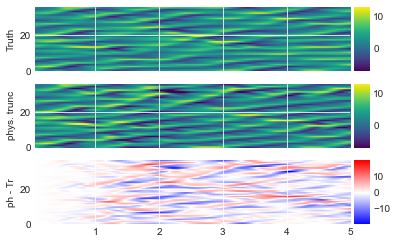

In [6]:
# Plot
chrono_plot_truth = Chronology(T=Tplot, dt=chrono_truth.dt, dtObs=chrono_truth.dtObs)
chrono_plot_trunc = Chronology(T=Tplot, dt=chrono_trunc.dt, dtObs=chrono_trunc.dtObs)



fig=plot_L96_2D(xxNu[chrono_plot_truth.kkObs,imemb],
                xx_trunc[chrono_plot_trunc.kkObs,imemb],
                chrono_plot_trunc.ttObs,['Truth','phys. trunc'])

## 2. compute_trainingset.py 
Run only if the experiment is a training experiment

In [7]:
# Load trainingset
if 'obstype' in exp: #If it is a training
    fname_train = os.path.join(expdir,template['train'].format(**dparam))
    data_train = np.load(fname_train)
    burn = exp['burn']
    xx_trainval = data_train['x'][burn:]
    yy_trainval = data_train['y'][burn:]
    #Check
    assert data_train['dtObs'] == dparam['dtObs']
    data_train.close()

In [8]:
if 'obstype' in exp:
    # Define a new chrono to include the burn
    chrono_plot_da = Chronology(T=chrono_plot_truth.T+burn*chrono_plot_truth.dtObs,
                                dt=chrono_plot_truth.dt,
                                dtObs=chrono_plot_truth.dtObs)


    # Comparison with the true simulation (=0 if obstype='perfect')
    fig = plot_L96_2D(xxNu[chrono_plot_da.kkObs[burn:],imemb],
                      xx_trainval[:chrono_plot_truth.KObs+1],
                      chrono_plot_truth.ttObs,
                      ['truth','da'])

In [9]:
if 'obstype' in exp:

    # set train/val limits
    ival = exp['ival']
    itrain = np.min((exp['maxtrain'], xx_trainval.shape[0] + np.abs(ival) - 1))

    #Training is taken at the begininng of the time series, Vaidation at the end
    xx_train, yy_train = xx_trainval[:itrain], yy_trainval[:itrain]
    xx_val, yy_val = xx_trainval[ival:], yy_trainval[ival:]
    print('Size of the training set:',xx_train.shape)
    print('Size of the validation set:',xx_val.shape)
    # Scatter plot of the output to be learnt (pointwise)
    fig, ax = plt.subplots(figsize=(10,5))
    sns.regplot(x=xx_train[:,icomp],y=yy_train[:,icomp], ax=ax, label='train')
    sns.regplot(x=xx_val[:,icomp],y=yy_val[:,icomp], ax=ax, label='validation')
    ax.set_xlabel('$x_{'+str(icomp)+'}$')
    ax.set_ylabel('$\epsilon^m$')
    ax.legend();

## 2. compute_nn.py 
Compute the output of the NN without simulation on the training/val set (only the next time step). Run only if the experiment is a training experiment

In [10]:
if 'obstype' in exp:

    #History
    fname_history = os.path.join(expdir,template['history'].format(**dparam))
    history = np.load(fname_history)
    fig, ax = plt.subplots()
    ax.plot(history['loss'], label='loss', color='gray')
    ax.plot(history['val_loss'], label='val_loss', color='black')
    ax.set_xlabel('epochs')
    ax.set_ylabel('L2 loss')
    ax.set_yscale('log')
    ax.legend();

In [18]:
if 'obstype' in exp:

    # Name of the weight file
    fname_weights = os.path.join(weightsdir, template['weights'].format(**dparam))

    # Parmaters of the NN
    parnn = exp['parnn']

    # Construct the model
    K.clear_session()
    model_nn = buildmodel(exp['archi'],reg=parnn['reg'],batchlayer=parnn['batch_layer'])
    model_nn.load_weights(fname_weights)

    # Predict the output for the train/validation set
    yy_train_predict = model_nn.predict(xx_train)
    yy_val_predict = model_nn.predict(xx_val)

In [19]:
if 'obstype' in exp:

    # Plot the results

    #Get min/max to format the axis
    mini = np.min([yy_train.min(), yy_train_predict.min(), yy_val.min(), yy_val_predict.min()])
    maxi = np.max([yy_train.max(), yy_train_predict.max(), yy_val.max(), yy_val_predict.max()])

    fig, ax = plt.subplots(figsize=(10,5))
    sns.regplot(x=yy_train[:,icomp],y=yy_train_predict[:,icomp], ax=ax, label='train')
    sns.regplot(x=yy_val[:,icomp],y=yy_val_predict[:,icomp], ax=ax, label='validation')
    ax.set_xlabel('$\epsilon^m target$')
    ax.set_ylabel('$\epsilon^m predicted$')
    ax.set_xlim([mini, maxi])
    ax.set_ylim([mini, maxi])
    ax.legend();


Note: if the dataset is derived from DA, the variability of the predicted value is much lower than the dynamic of the target value which is expected because the target value is noisy. The NN is predicting only the relevant information and is not supposed to predict white noise.

### 3. Compute output
Compute the output of the NN without simulation on the true set (only the next time step). In the perfect obs-derived experiment, gives the same results as the previous plot.

In [20]:
# Reload NN (if not already done previoulsy)

# Name of the weight file
fname_weights = os.path.join(weightsdir, template['weights'].format(**dparam))

# Parmaters of the NN
parnn = exp['parnn']

# Construct the model
K.clear_session()
model_nn = buildmodel(exp['archi'],reg=parnn['reg'],batchlayer=parnn['batch_layer'])
model_nn.load_weights(fname_weights)

In [21]:
xx_sub = xxNu[chrono_truth.kkObs,imemb]
# To spare some time, plot only the last 10000 values
xx_sub = xx_sub[-10000:] #Comment this line to plot the whole dataset
print("Size of the reference dataset (time steps,state size):",xx_sub.shape)

# Run the truncated model
model_module = __import__(model['model_module'])
HMM_trunc = getattr(model_module, model['model_name'])
trunc_model = with_recursion(HMM_trunc.Dyn.model)

# Compute epsilon
xx_in = xx_sub[:-1]

# Estimation of the true value after dtObs MTU
xx_out = xx_sub[1:]

# Truncated value after dtObs MTU
xx_trunc = trunc_model(xx_in, chrono_trunc.dkObs, np.nan, chrono_trunc.dt)[-1]

# Estimation of the model error
delta = (xx_out - xx_trunc) / dparam['dtObs']

# Run the neural network
delta_pred = model_nn.predict(xx_in)

Size of the reference dataset (time steps,state size): (300, 36)


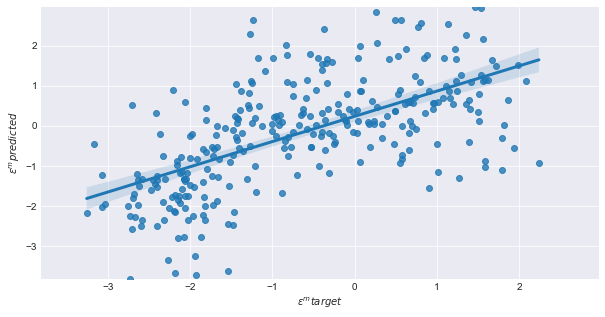

In [27]:
# Plot the results

#Get min/max to format the axis
mini = np.min([delta[:,icomp].min(), delta_pred[:,icomp].min()])
maxi = np.max([delta[:,icomp].max(), delta_pred[:,icomp].max()])

fig, ax = plt.subplots(figsize=(10,5))
sns.regplot(x=delta[:,icomp],y=delta_pred[:,icomp], ax=ax)
ax.set_xlabel('$\epsilon^m target$')
ax.set_ylabel('$\epsilon^m predicted$')
ax.set_xlim([mini, maxi]);
ax.set_ylim([mini, maxi]);


## 4. Simul hybrid model


In [31]:
# Load the hybrid simulation
fname_hybrid = os.path.join(expdir,template['hybrid'])
data_hybrid = np.load(fname_hybrid.format(**dparam))
chrono_hybrid = Chronology(T=data_hybrid['T'],dt=float(data_hybrid['dt']),dtObs=dparam['dtObs'])
xx_hybrid = data_hybrid['xx']

print('Size of the hybrid dataset (time steps, ensemble size, state size):',xx_hybrid.shape)

data_hybrid.close()


Size of the hybrid dataset (time steps, ensemble size, state size): (1501, 20, 36)


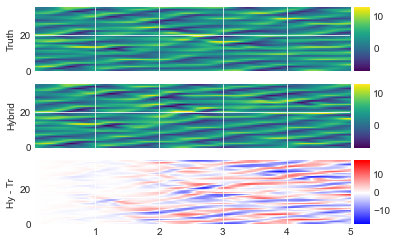

In [32]:
fig=plot_L96_2D(xxNu[chrono_plot_truth.kkObs,imemb],
                xx_hybrid[chrono_plot_trunc.kkObs,imemb],
                chrono_plot_trunc.ttObs,['Truth','Hybrid'])